In [1]:
# Print runtime spec
import os
import platform
import psutil
import subprocess

# CPU info
print("=== CPU Info ===")
print(f"Processor: {platform.processor()}")
print(f"CPU Cores: {psutil.cpu_count(logical=False)} physical / {psutil.cpu_count()} logical")
cpu_freq = psutil.cpu_freq()
if cpu_freq:
    print(f"CPU Frequency: {cpu_freq.current:.2f} MHz")

# RAM info
print("\n=== RAM Info ===")
ram = psutil.virtual_memory()
print(f"Total RAM: {ram.total / (1024 ** 3):.2f} GB")
print(f"Available RAM: {ram.available / (1024 ** 3):.2f} GB")

# GPU info (NVIDIA)
print("\n=== GPU Info ===")
try:
    result = subprocess.run(
        ['nvidia-smi', '--query-gpu=name,memory.total,memory.used,driver_version', '--format=csv,noheader,nounits'],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True, text=True
    )
    gpus = result.stdout.strip().split('\n')
    for idx, gpu in enumerate(gpus):
        name, mem_total, mem_used, driver = [x.strip() for x in gpu.split(',')]
        print(f"GPU {idx}: {name}")
        print(f"  Total Memory: {mem_total} MB")
        print(f"  Used Memory: {mem_used} MB")
        print(f"  Driver Version: {driver}")
except FileNotFoundError:
    print("nvidia-smi not found. NVIDIA GPU may not be installed.")
except subprocess.CalledProcessError as e:
    print(f"Error running nvidia-smi: {e}")


=== CPU Info ===
Processor: x86_64
CPU Cores: 1 physical / 2 logical
CPU Frequency: 2200.00 MHz

=== RAM Info ===
Total RAM: 12.67 GB
Available RAM: 11.20 GB

=== GPU Info ===
GPU 0: Tesla T4
  Total Memory: 15360 MB
  Used Memory: 0 MB
  Driver Version: 550.54.15


Usage rate: approximately 1.43 per hour

# **Step 1. Setup the environment**

In [2]:
%%capture
!pip install -q scanpy==1.10.1
!pip install -q anndata==0.10.7
!pip install -q leidenalg==0.10.2
!pip install google-cloud-storage

!pip install -q 'rapids-singlecell[rapids12]' --extra-index-url=https://pypi.nvidia.com #CUDA12
!pip install -q rmm-cu12 # RMM: RAPIDS Memory Manager

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc_context

import time
import rapids_singlecell as rsc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)

Follow the instruction to allow access to google drive to save data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth # Authenticate your Colab environment to access your Google Cloud account.
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Step 2. Load data and create a scanpy object**

In [5]:
# directly load from https://info.vizgen.com/protein-co-detection-showcase?submissionGuid=b2c89505-7fbc-453a-bbe0-0add9691c2fe
cell_by_gene_csv = 'gs://vz-ffpe-showcase/HumanUterineCancerPatient2-ROCostain/cell_by_gene.csv'
meta_cell_csv = 'gs://vz-ffpe-showcase/HumanUterineCancerPatient2-ROCostain/cell_metadata.csv'

In [6]:
def make_AnnData(cell_by_gene_path, meta_cell_path, frac, random_state): # downsize to fit ram

    cell_by_gene = pd.read_csv(cell_by_gene_path, index_col=0)
    cell_by_gene.index = [str(i) for i in cell_by_gene.index] # this ensure the cell IDs are strings
    cell_by_gene = cell_by_gene.sample(frac = frac, random_state= random_state)

    meta_cell = pd.read_csv(meta_cell_path, index_col=0)
    meta_cell.index = [str(i) for i in meta_cell.index] # this ensure the cell IDs are strings
    meta_cell = meta_cell.sample(frac = frac, random_state= random_state)

    meta_cell['barcodeCount'] = cell_by_gene.sum(axis=1)

    # initialize meta_gene
    meta_gene = pd.DataFrame(index=cell_by_gene.columns.tolist())

    # Align the cell id of cell_by_gene and cell_metadata
    cell_id = cell_by_gene.index.tolist()
    meta_cell = meta_cell.loc[cell_id]

    coordinates =np.stack((meta_cell['center_x'], meta_cell['center_y']), axis=1)

    ad = sc.AnnData(X=cell_by_gene.values, obs=meta_cell, var=meta_gene, obsm={"spatial": coordinates})
    return ad

In [7]:
adata = make_AnnData(cell_by_gene_csv, meta_cell_csv, frac = 0.1, random_state=1128)
# Filtering out blank genes
adata = adata[:, adata.var_names.str.startswith('Blank-')==False]

# Storing the counts for later use
adata.layers["counts"] = adata.X.copy()

adata

/tmp/ipython-input-7-2845559104.py:6: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


AnnData object with n_obs × n_vars = 75851 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Anti-Ms-CD45RO_raw', 'Anti-Ms-CD45RO_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'barcodeCount'
    obsm: 'spatial'
    layers: 'counts'

# **Step 3. Single cell anaysis**

In [8]:
data_processing_start = time.time()

In [9]:
%%time

# set the threshold
min_barcode_count_threshold = 20
volume_upper_threshold = 2500
volume_lower_threshold = 100

selectCells = adata.obs[(adata.obs.volume < volume_upper_threshold)
                   & (adata.obs.volume > volume_lower_threshold)
                   & (adata.obs.barcodeCount > min_barcode_count_threshold)].index

# Transfers matrices and arrays to the GPU
adata = adata[selectCells].copy()

# Normalize barcode counts by cell volume
adata.obs['volume_factor'] = adata.obs['volume']/np.median(adata.obs['volume'])
adata.X = np.divide(adata.X, np.array(adata.obs['volume_factor']).reshape(-1, 1))


CPU times: user 565 ms, sys: 57.5 ms, total: 623 ms
Wall time: 642 ms


In [10]:
%%time
rsc.get.anndata_to_GPU(adata)

CPU times: user 78.9 ms, sys: 503 ms, total: 581 ms
Wall time: 662 ms


In [11]:
%%time

# Normalize barcode counts by total counts over all genes and log transform data
# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)
rsc.pp.normalize_total(adata)
rsc.pp.log1p(adata)


# Store raw data in the .raw attribute before scaling
adata.raw = adata.copy()

# scale gene counts
# sc.pp.scale(adata, max_value=10)
rsc.pp.scale(adata, max_value=10)

# PCA
# sc.tl.pca(adata, svd_solver='arpack')
# sc.tl.pca(adata)
rsc.tl.pca(adata)
# sc.pl.pca_variance_ratio(adata, log=True) # use elbow plot to determine the number of PCs

# Connect neighbors and embed in UMAP
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
rsc.pp.neighbors(adata) # n_neighbors=15, n_pcs=None # Same default param as scanpy
rsc.tl.umap(adata)

# Cluster cells using the Leiden algorithm
# sc.tl.leiden(adata, resolution=1.5)
rsc.tl.leiden(adata, resolution=1.5)

CPU times: user 3.57 s, sys: 734 ms, total: 4.31 s
Wall time: 7.14 s


# Rank genes (Differential expression)

defaulting to using `.raw`
[2025-07-22 14:46:38.060] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-22 14:46:38.065] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


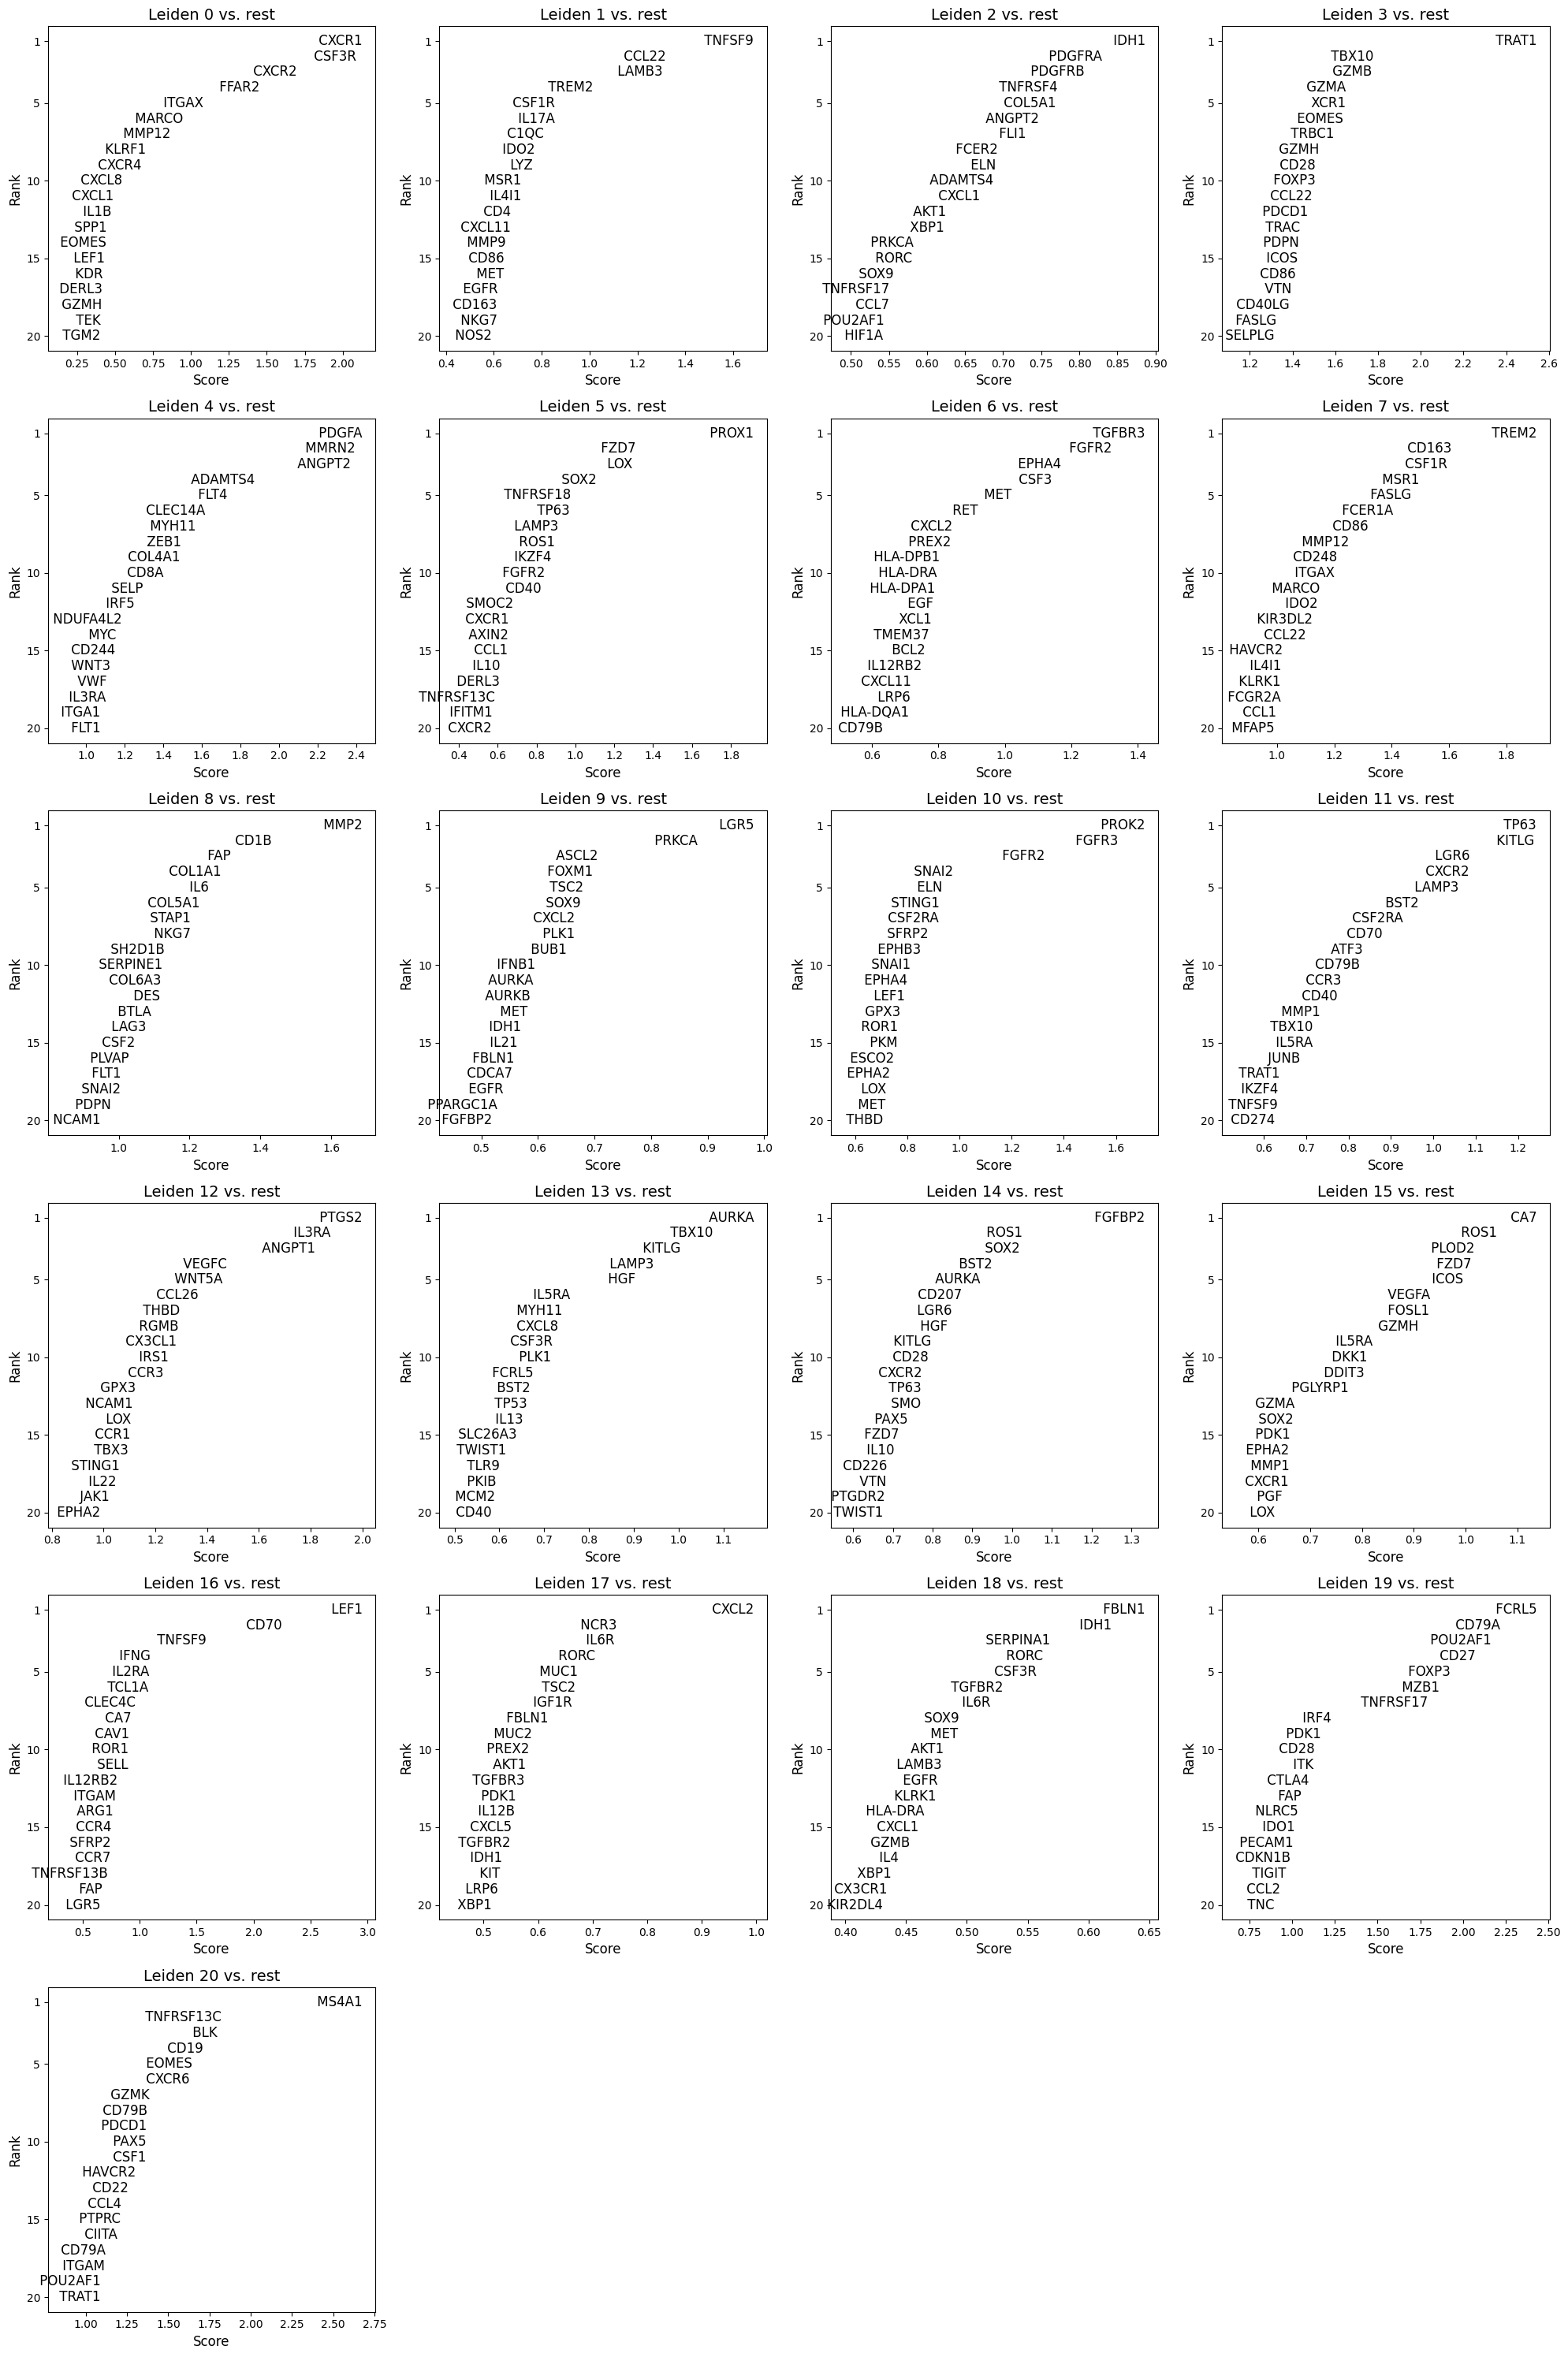

CPU times: user 40.3 s, sys: 7.12 s, total: 47.4 s
Wall time: 48.8 s


In [12]:
%%time

# Rank genes (Differential expression)
# sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
rsc.tl.rank_genes_groups_logreg(adata, groupby="leiden")
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
# sc.pl.rank_genes_groups(adata, n_genes=20, fontsize=12, ncols=3, sharey=False)

# Plot gene rank
# swop x and y axis to make gene names in horizontal for better visualization

# Number of clusters
n_clusters = len(adata.obs['leiden'].unique())
n_rows = 6
n_cols = 4
n_genes = 20  # Number of genes to visualize

# Define subplot size
subplot_width = 5  # Width of each subplot
subplot_height = 5  # Height of each subplot

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * subplot_width, n_rows * subplot_height))
axes = axes.flatten()  # Flatten the grid to iterate easily

# Loop over each Leiden cluster
for i in range(n_clusters):
    group = str(i)  # Leiden cluster name as a string
    ax = axes[i]  # Select the corresponding subplot

    # Extract rank genes information
    genes = adata.uns['rank_genes_groups']['names'][group][:n_genes]
    scores = adata.uns['rank_genes_groups']['scores'][group][:n_genes]

    # Creating a DataFrame for ease of plotting
    data = pd.DataFrame({'Rank': range(1, n_genes + 1), 'Gene': genes, 'Score': scores})

    # Plotting on the subplot
    ax.scatter(data['Score'], data['Rank'], color='blue', s=0)  # Make dots invisible by setting size to 0
    ax.invert_yaxis()  # Invert y-axis to have rank 1 at the top

    # Adding gene name labels next to dots
    for j, row in data.iterrows():
        ax.text(row['Score'], row['Rank'], f" {row['Gene']}", va='center', ha='right', fontsize=12)

    # Adjusting y-axis to show only specific ranks
    ax.set_yticks([1, 5, 10, 15, 20])
    ax.set_yticklabels([1, 5, 10, 15, 20])
    ax.tick_params(axis='x', labelsize=10)  # Adjust x-axis tick size
    ax.tick_params(axis='y', labelsize=10)  # Adjust y-axis tick size

    # Adjusting x-axis min
    xmin = data['Score'].min() - (data['Score'].max()-data['Score'].min())*.2
    ax.set_xlim(xmin, None)  # Set xmin, leaving xmax as automatic

    # Formatting the subplot
    ax.set_title(f'Leiden {group} vs. rest', fontsize=14)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('Rank', fontsize=12)

# Leave the last subplot blank
for i in range(n_clusters, len(axes)):
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# Plot ranking of genes using dotplot




    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


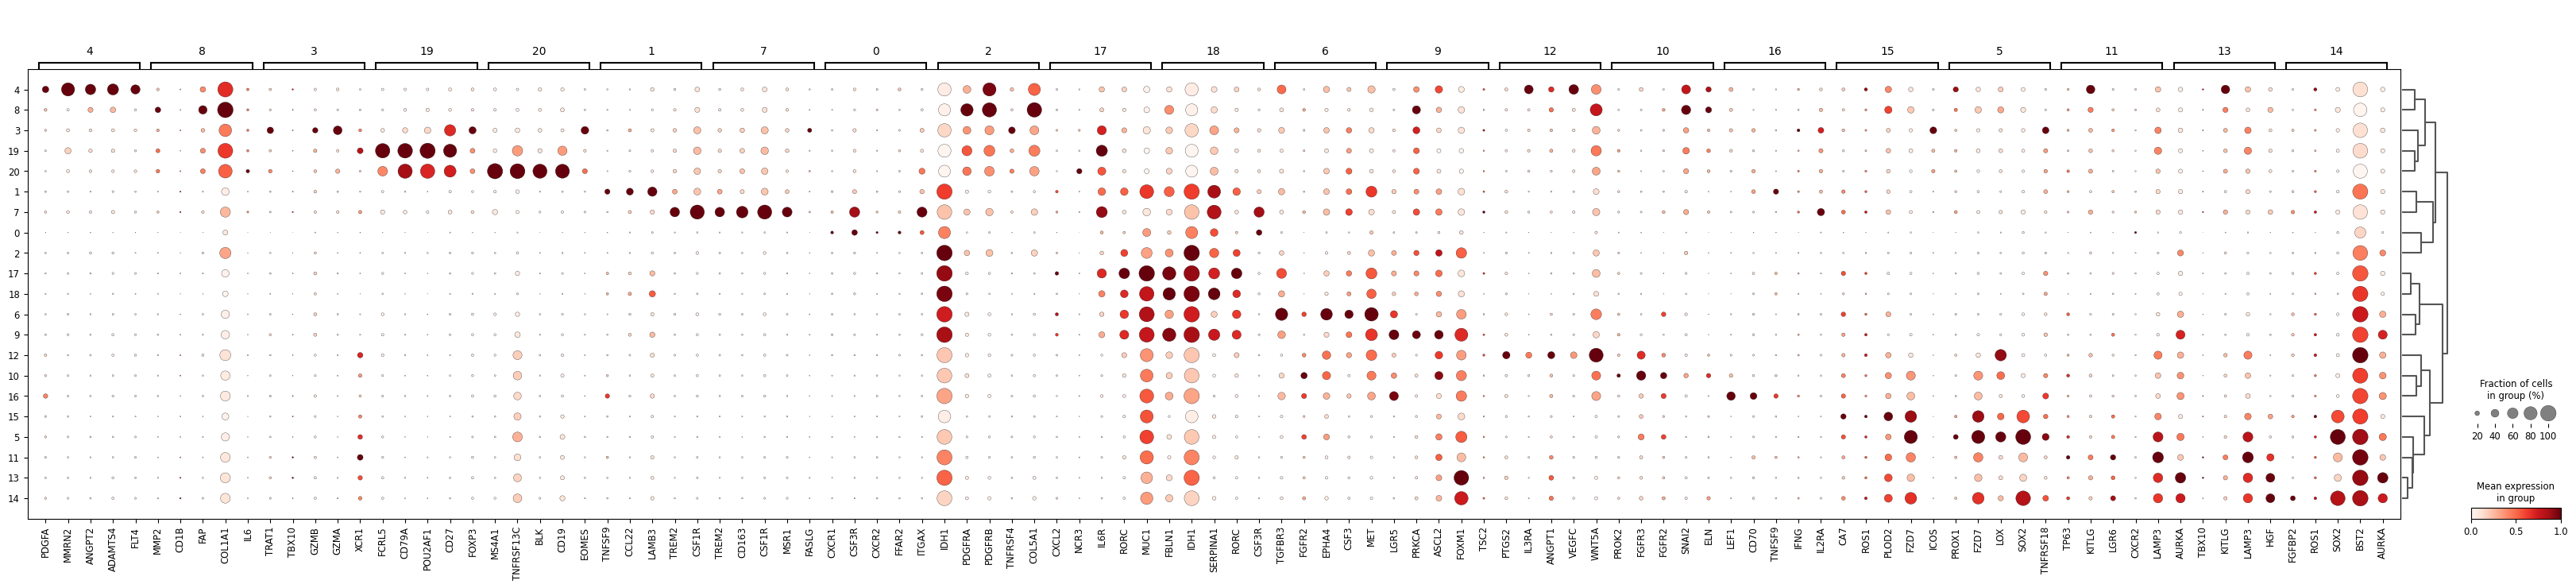

In [13]:
sc.pl.rank_genes_groups_dotplot(adata, groupby='leiden',n_genes=5, standard_scale='var')

In [14]:
data_processing_time = time.time()
elapsed_seconds = data_processing_time - data_processing_start
elapsed_minutes = elapsed_seconds / 60

print("Total data processing time: %.2f minutes" % elapsed_minutes)


Total data processing time: 0.98 minutes


# **Step 4. Visualize clusters on UMAP and spatial distribution**

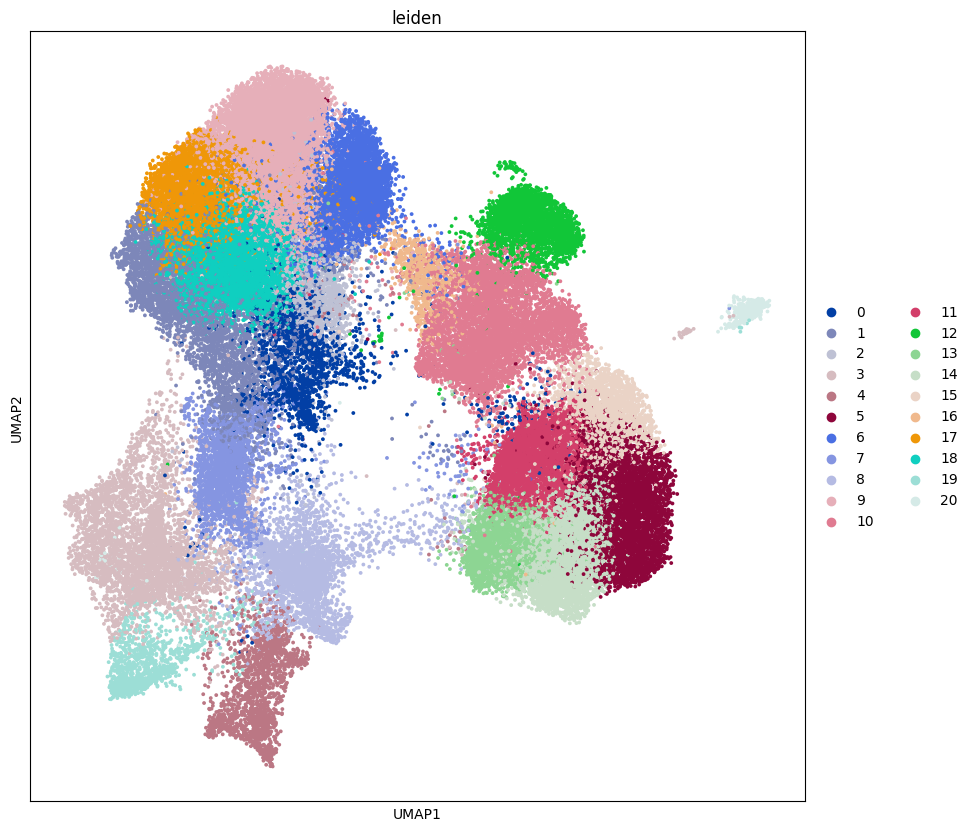

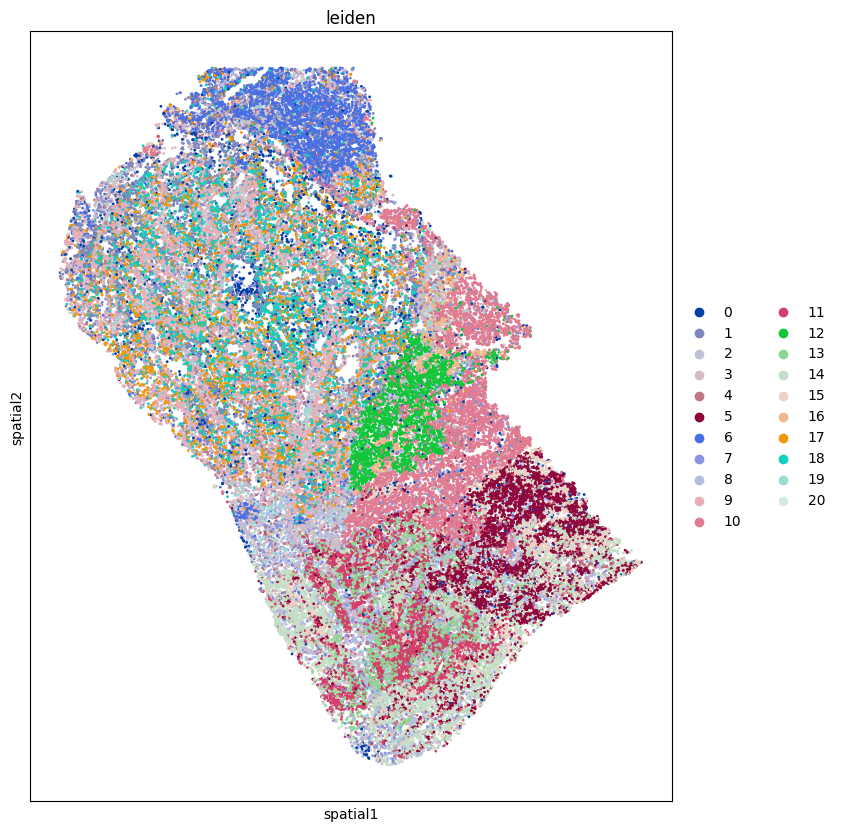

In [15]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color="leiden", size= 30, alpha = 1)

with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(adata, color='leiden', spot_size=50, alpha = 1)

# Investigate the UMAP differences
Cell distribution on rapids-singlecell derived UMAP is different from the Scanpy workflow.

In [17]:
adata.layers["counts"]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       [1, 3, 1, ..., 0, 0, 6],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
adata.X

array([[ 0.75371606, -0.18906709, -0.34926766, ..., -0.19087914,
        -0.17958894, -1.00927366],
       [-0.68554515, -0.18906709,  2.01158709, ..., -0.19087914,
        -0.17958894,  0.07126399],
       [ 0.23888929,  6.82534275,  1.08461601, ..., -0.19087914,
        -0.17958894,  1.14474347],
       ...,
       [-0.68554515, -0.18906709, -0.34926766, ..., -0.19087914,
        -0.17958894, -1.00927366],
       [-0.68554515, -0.18906709, -0.34926766, ..., -0.19087914,
        -0.17958894,  0.10708855],
       [-0.68554515, -0.18906709, -0.34926766, ..., -0.19087914,
        -0.17958894, -1.00927366]])

The input raw counts and the normalized-logTransformed-scaled counts are the same as Scanpy workflow.

## Check principle component (PC) loads

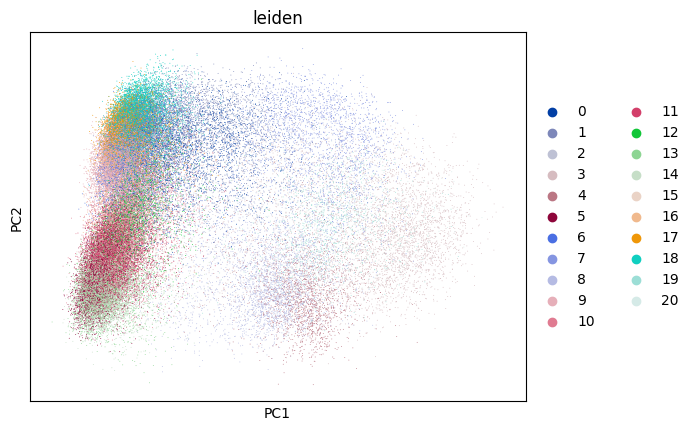

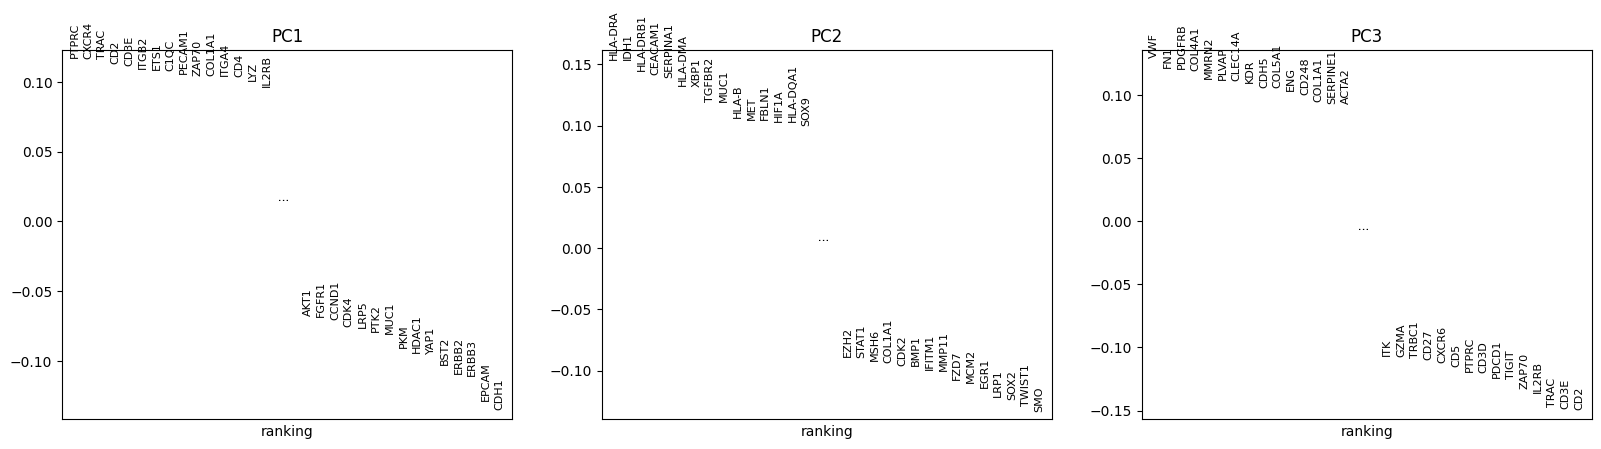

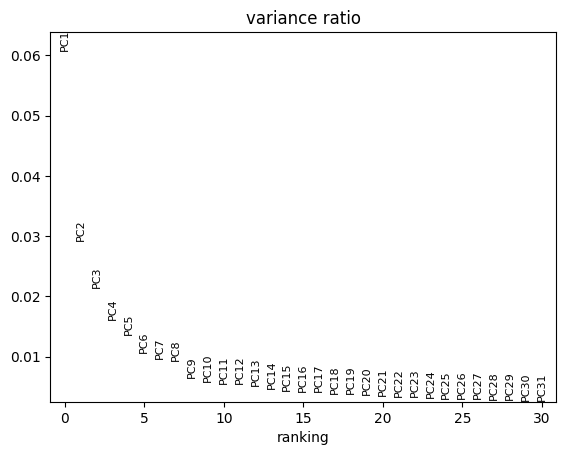

In [19]:
sc.pl.pca_overview(adata, color="leiden")

In [20]:
pc_df = pd.DataFrame(adata.varm['PCs'], index = adata.var_names)
pc_df

0         1         2         3         4         5         6   \
PDK4     0.021157  0.055534 -0.004367 -0.008414 -0.076987 -0.017839  0.026516   
CCL26    0.003318 -0.005867  0.005521  0.003824 -0.009914 -0.010143 -0.004537   
CX3CL1   0.027214 -0.004745  0.045062  0.039492 -0.012821 -0.038855 -0.029423   
PGLYRP1  0.002342 -0.002685 -0.005732 -0.002335 -0.014614  0.004515 -0.000427   
CD4      0.103488  0.023410 -0.062501 -0.067177 -0.049656  0.022230  0.019864   
...           ...       ...       ...       ...       ...       ...       ...   
ATM      0.007903 -0.014287 -0.027529  0.012697 -0.034893 -0.022337 -0.037668   
PRF1     0.035391  0.002467 -0.058514  0.030400  0.006361  0.033879  0.024710   
IL10     0.020682 -0.007009 -0.001783 -0.014209 -0.019082 -0.001877  0.000907   
IL17A   -0.001492 -0.004314 -0.004039 -0.004654 -0.015869  0.003901  0.002350   
NOTCH1   0.010611 -0.076676 -0.020329  0.016601 -0.050985  0.070274 -0.017164   

               7         8         9   ...        40        41        42  \
PDK4     0.000449 -0.027560 -0.001789  ...  0.029565  0.054172  0.072141   
CCL26   -0.013809 -0.011759  0.020060  ... -0.058458 -0.043588 -0.002678   
CX3CL1  -0.064029 -0.044209  0.035181  ... -0.000334 -0.050670 -0.000704   
PGLYRP1 -0.002467 -0.002720  0.012703  ... -0.042487 -0.017112  0.027212   
CD4     -0.023304  0.011710  0.032525  ...  0.009439 -0.020932 -0.011715   
...           ...       ...       ...  ...       ...       ...       ...   
ATM     -0.002984 -0.001286  0.001823  ...  0.008437 -0.019889  0.019843   
PRF1    -0.025664 -0.009972 -0.018268  ...  0.053274 -0.004436 -0.040225   
IL10    -0.018149 -0.016969  0.005648  ... -0.030400 -0.016383  0.016102   
IL17A   -0.000235 -0.000728  0.009566  ... -0.044263  0.007060 -0.001628   
NOTCH1   0.007151 -0.075969  0.063042  ...  0.085103 -0.034326  0.013820   

               43        44        45        46        47        48        49  
PDK4     0.020837 -0.036340 -0.005631  0.006338  0.054814 -0.039652  0.048536  
CCL26   -0.071464  0.072804  0.141240 -0.024382 -0.060346  0.054734 -0.068237  
CX3CL1  -0.039494  0.106687 -0.170723  0.031405  0.045042  0.002672  0.056228  
PGLYRP1 -0.023934  0.008172  0.019123  0.034991  0.013346  0.001593 -0.000644  
CD4     -0.028352  0.013352 -0.026133  0.024808 -0.015732 -0.001260  0.011005  
...           ...       ...       ...       ...       ...       ...       ...  
ATM      0.037960 -0.041530  0.033295 -0.063968 -0.008683  0.045154 -0.068228  
PRF1    -0.004605  0.042254  0.022648  0.067466  0.017279 -0.022899  0.030101  
IL10    -0.010912 -0.076887  0.045384  0.044973  0.016126 -0.063720  0.055570  
IL17A   -0.007776  0.036890 -0.091370  0.008459 -0.059288  0.007834 -0.097013  
NOTCH1  -0.035275  0.008165 -0.002082 -0.016633  0.096661 -0.075141  0.082252  

[500 rows x 50 columns]

In [21]:
# rank PC1
display(pc_df[0].sort_values(ascending=False).head(20))
display(pc_df[0].sort_values(ascending=False).tail(20))

PTPRC     0.117104
CXCR4     0.116983
TRAC      0.116430
CD2       0.113372
CD3E      0.111741
ITGB2     0.109634
ETS1      0.109101
C1QC      0.108171
PECAM1    0.105675
ZAP70     0.104681
COL1A1    0.104598
ITGA4     0.104159
CD4       0.103488
LYZ       0.101021
IL2RB     0.096677
CD27      0.095631
PDGFRB    0.094003
COL5A1    0.093520
TGFBI     0.092031
FN1       0.091834
Name: 0, dtype: float64

CHEK2    -0.063544
TP53     -0.064540
NFE2L2   -0.065541
EPHB4    -0.065550
CDK2     -0.067287
AKT1     -0.067418
FGFR1    -0.068699
CCND1    -0.070447
CDK4     -0.075236
LRP5     -0.076198
PTK2     -0.079209
MUC1     -0.080669
PKM      -0.090781
HDAC1    -0.093926
YAP1     -0.095077
BST2     -0.102436
ERBB2    -0.108935
ERBB3    -0.110764
EPCAM    -0.128501
CDH1     -0.135302
Name: 0, dtype: float64

In [22]:
# rank PC2
display(pc_df[1].sort_values(ascending=False).head(20))
display(pc_df[1].sort_values(ascending=False).tail(20))

HLA-DRA     0.154111
IDH1        0.153835
HLA-DRB1    0.144914
CEACAM1     0.141323
SERPINA1    0.138730
HLA-DMA     0.132702
XBP1        0.131532
TGFBR2      0.119792
MUC1        0.119690
HLA-B       0.106600
MET         0.105055
FBLN1       0.104627
HIF1A       0.103560
HLA-DQA1    0.103151
SOX9        0.100206
HLA-DPB1    0.092565
IGF1R       0.091649
HLA-C       0.089520
TAPBP       0.089247
RORC        0.088962
Name: 1, dtype: float64

AKT3     -0.082132
HGF      -0.082290
PCNA     -0.083524
CHEK1    -0.083764
IRF3     -0.083849
EZH2     -0.088554
STAT1    -0.089008
MSH6     -0.092142
COL1A1   -0.093799
CDK2     -0.095797
BMP1     -0.096214
IFITM1   -0.099574
MMP11    -0.099837
FZD7     -0.107032
MCM2     -0.109621
EGR1     -0.113734
LRP1     -0.120912
SOX2     -0.123501
TWIST1   -0.128822
SMO      -0.133156
Name: 1, dtype: float64

## Negate the first PC and repeat the Scanpy result

In [ ]:

adata.varm['PCs'][:, 0] = -adata.varm['PCs'][:, 0]
adata.obsm['X_pca'][:, 0] = -adata.obsm['X_pca'][:, 0]

# re-cluster
rsc.pp.neighbors(adata)
rsc.tl.umap(adata)

rsc.tl.leiden(adata, resolution=1.5)


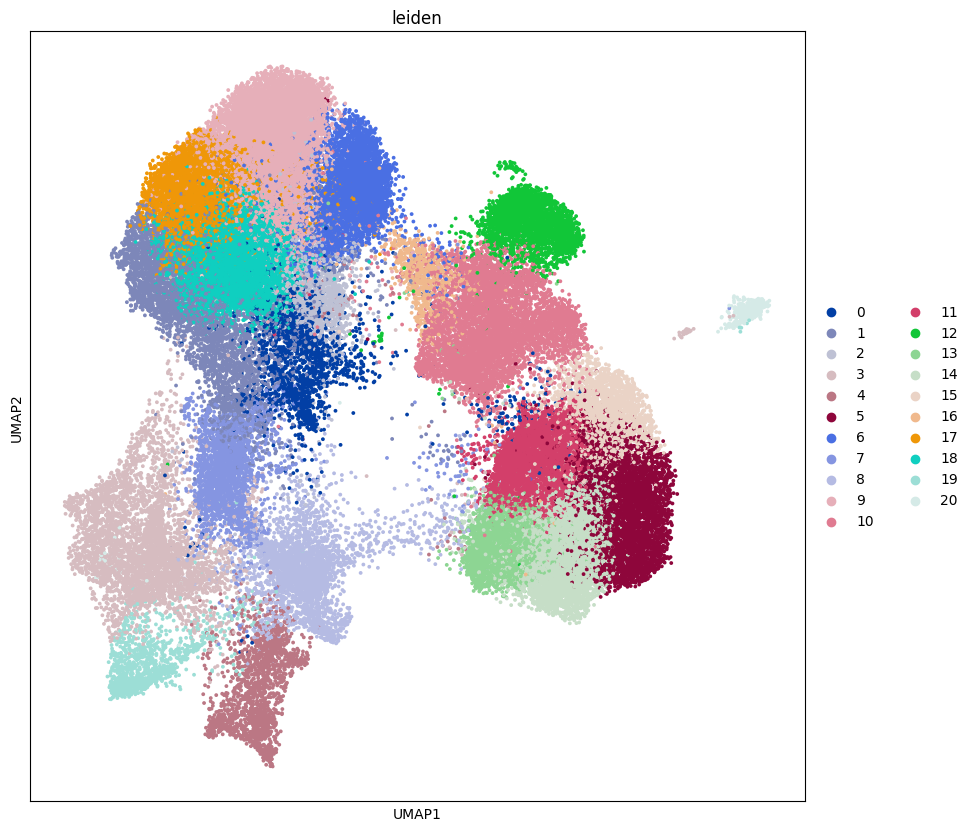

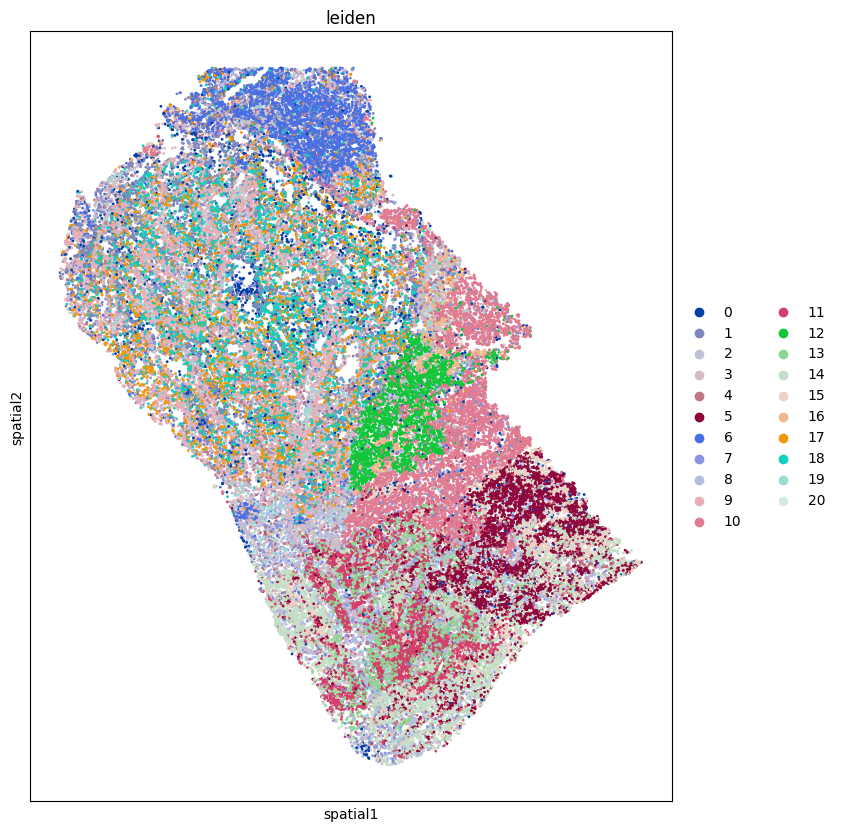

In [25]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color="leiden", size= 30, alpha = 1)

with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(adata, color='leiden', spot_size=50, alpha = 1)

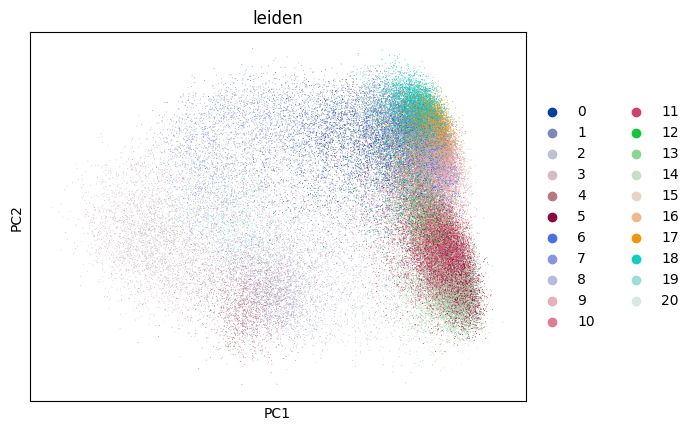

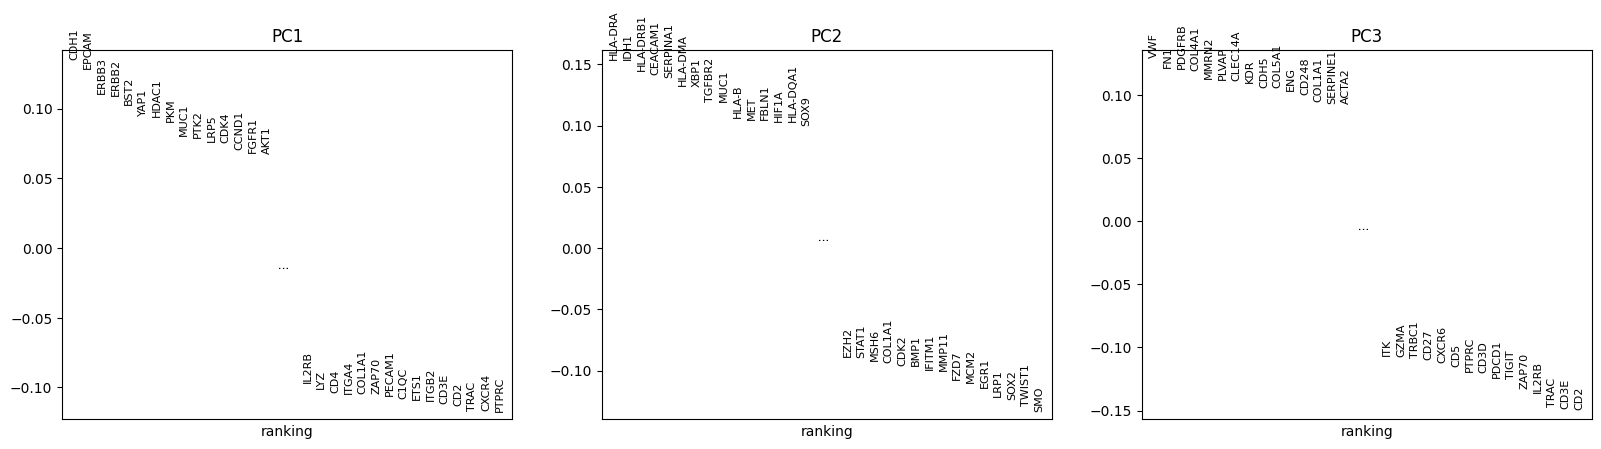

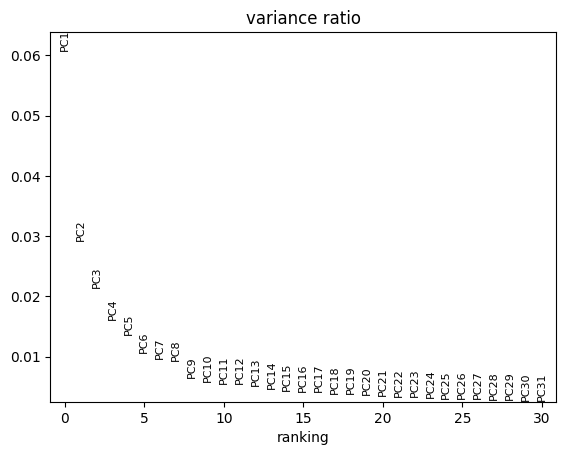

In [26]:
sc.pl.pca_overview(adata, color="leiden")

In [27]:
# print out session information
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.9.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
anndata                               0.10.7
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array-api-compat                      1.12.0
array_record                          0.7.2
arviz                                 0.21.0
astrop